# Part 4: Ridge and Lasso Regression Models

## Problem Statement:

**Based on the Ames, Iowa housing data, which housing features are the most pertinent to a house's sales price, and thus can more accuraely predict a house's price?** 

[The Ames Iowa Housing Data](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) contains 81 variables that were used in computing assessed values for individual residential properties sold from 2006 to 2010. I will be using various regression models, such as Linear Regression, LassoCV, and RidgeCV, to determine which model most accurately fits the data by comparing RMSE and $R^2$ scores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from scipy import stats
import statsmodels.api as sm
import string
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import VarianceThreshold
from statistics import mode

np.random.seed(3_0_0)

DO = '#7D1B7E'
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
train_dummies = pd.read_csv('../datasets/train_dummies.csv', keep_default_na=False)

In [3]:
train_dummies.isnull().sum().sum()

0

## Ridge Regression Model

$$ \text{minimize:}\; SSE+Ridge = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\sum_{j=1}^p \beta_j^2$$

Due to the high $R^2$ of 88% in both MLR train and test scores, the model suffers from high error due to variance, and is thus overfit.

In order to reduce the error from multicollinearity among the predictor variables and prevent the model from overfitting, a ridge regression model will be used to reduce the beta coefficient weights by regularization. 

The **alpha** hyperparameter in the ridge regression penalizes extra predictor variables which is useful, because more predictor variables increase variance and lead to overfitting in the model. In general, alpha increases the affect of regularization. If alpha is zero there is no regularization and the higher the alpha, the more the regularization parameter influences the final model.

As a result, the ridge regression model minimizes coefficient weights.

I will first split the dataset into the predictor variables, `X`, and dependent variable, `y`. The `X` variables contain all the columns except for the `SalePrice`. The `y` is the `SalePrice` column as I am trying to create a model that will predict the sale price of homes based on their house features. 

I will then utilize a train test split, with a train size of 70%. This means the model will be created by only using 70% of the data, and the remaining 30% will be used to test whether the model is robust enough to predict future sale prices based on inputs that it has not seen before.

In [4]:
X = train_dummies.drop(columns = 'SalePrice', axis = 1)
y = train_dummies['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 42, train_size = 0.7);

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Prior to fitting the model, I will utilize a variance threshold to remove low variance predictor variables

Furthermore, there are vastly different units for the predictor variables. In order to mitigate this issue, it will be appropriate to use a standard scaler to normalize all the variables' distributions.

In [5]:
threshold = VarianceThreshold(.01)

X_train_thresh = threshold.fit_transform(X_train)
X_test_thresh = threshold.transform(X_test)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_thresh)
X_test_sc = ss.transform(X_test_thresh)

I will then use a ridge regression, which chooses the best alpha, based on a range from 1 to 10000, to fit the model on.

In [6]:
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas = r_alphas, cv = 5)
ridge_cv.fit(X_train_sc, y_train)
   
R2_train = ridge_cv.score(X_train_sc, y_train)
R2_test = ridge_cv.score(X_test_sc, y_test)

print(f'Optimal Alpha: {ridge_cv.alpha_}')
print(f'Train R2 Score: {R2_train}')
print(f'Test R2 Score: {R2_test}')

Optimal Alpha: 756.463327554629
Train R2 Score: 0.886401338272029
Test R2 Score: 0.9019785874924591


The optimal alpha chosen by the ridge model is 756. 

Based on the ridge model above, the train $R^2$ is 88.6% and the test $R^2$ is 90.1%. The model apparently fits the test data better than the training dataset which may be an anomaly. There might be a risk of overfitting.

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.,  600000.,  700000.]), <a list of 9 Text xticklabel objects>)

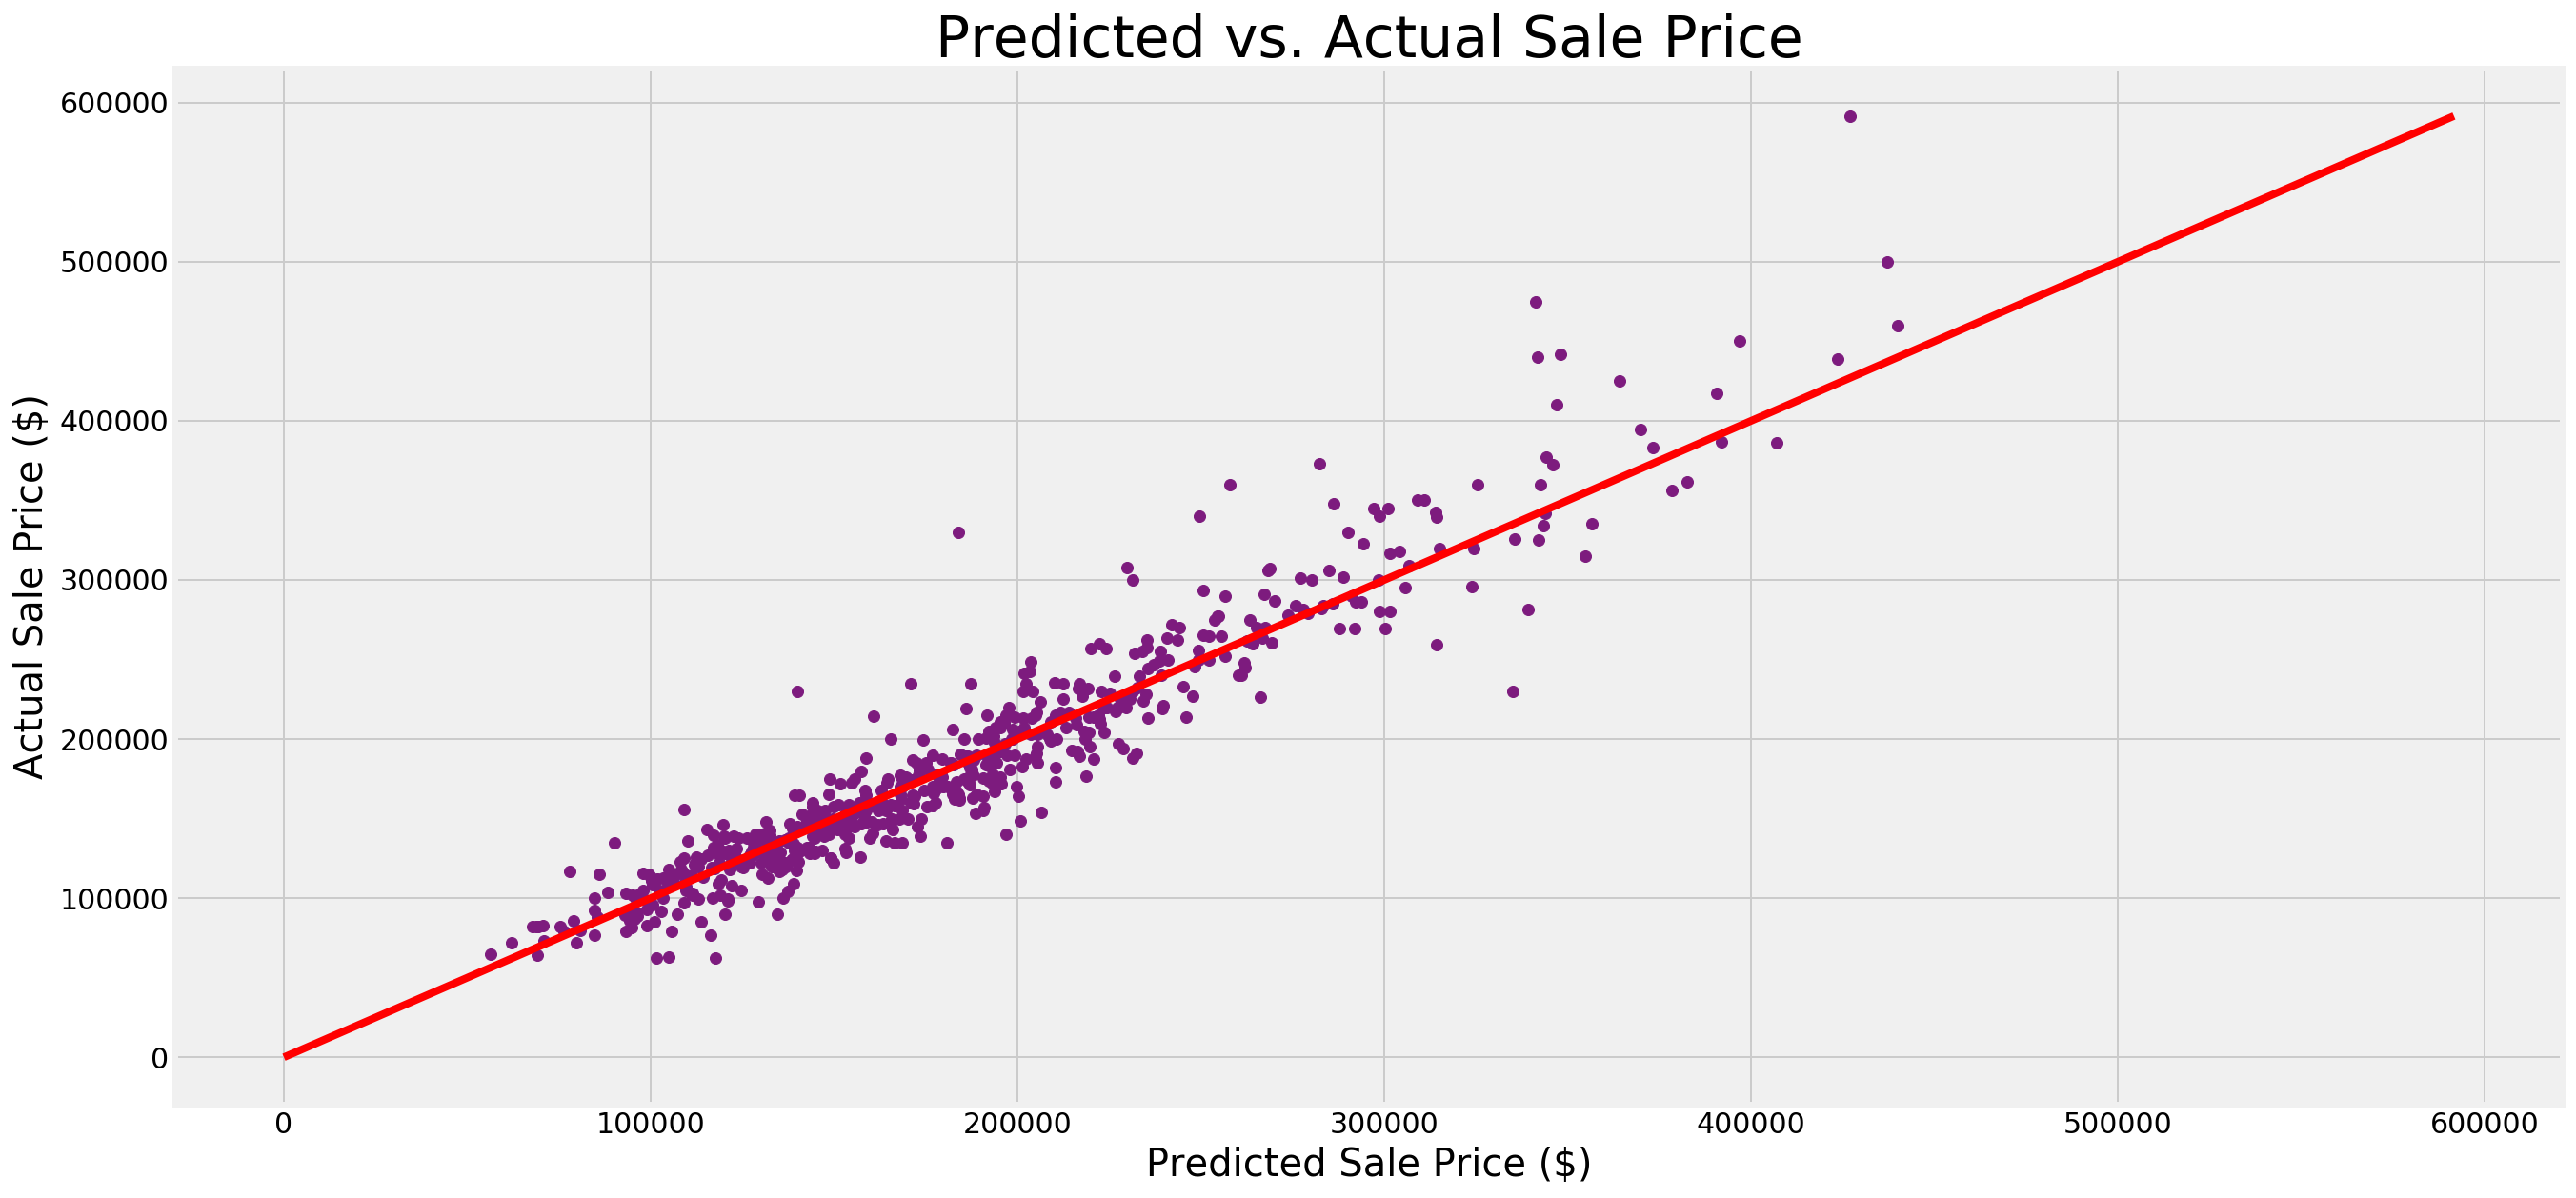

In [7]:
y_hat_rr = ridge_cv.predict(X_test_sc)

plt.figure(figsize = (20,10))
plt.scatter(y_hat_rr,y_test, c = DO);
plt.plot((0,np.max(y_test)),(0,np.max(y_test)), c = 'red');
plt.xlabel("Predicted Sale Price ($)", fontsize = 20);
plt.ylabel("Actual Sale Price ($)", fontsize = 20);
plt.title("Predicted vs. Actual Sale Price", fontsize = 30);
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

The predicted vs. actual sale price graph shows the actual sale price of the house plotted against its predicted sale price generated from the ridge regression model.

The straight red line is the identity line which shows how close our predictions are from our actual sale prices. 
For example, if a purple dot lands exactly on the red line, that explains how the model predicted that particular house’s sale price to its actual price perfectly.

Errors of the model can be calculated by the distance between the purple dots and the red identity line. 

As you can see, the model has done fairly well for housing prices between 100,000 to 250,000 dollars. This encompasses the median home value which is around $165,000.

Unfortunately, many of the errors are for houses that are above the median home values. At around 300,000 to 450,000 homes, the sale price predictions are way off of the model.

In [8]:
def model_score(y_true,y_hat):
    
    RMSE = round(mean_squared_error(y_true , y_hat)**0.5,2)
    R2 = round(r2_score(y_true,y_hat),3)
    MAE = round(mean_absolute_error(y_true,y_hat),2)
    MedAE = round(median_absolute_error(y_true,y_hat),2)
    
    print(f'Mean Absolute Error: {MAE}\nMedian Absolute Error: {MedAE}\nRoot Mean Squared Error: {RMSE}\nR2: {R2}')


In [9]:
model_score(y_test, y_hat_rr)

Mean Absolute Error: 16053.48
Median Absolute Error: 10675.32
Root Mean Squared Error: 24095.8
R2: 0.902


Based on the ridge model's metrics, it has performed better than the previous multiple linear regression models. The ridge regression has the lowest MAE, MedAE, and RMSE, while having the highest test $R^2$ score.

Based on the RMSE score, the ridge model can predict a house's price ± \\$24,095

However, it has a high number of predictor variables, 216, which should be reduced because the more regressors there are, the lower the RSS (residual sum of squares) and the higher the $R^2$.

| Metric | VT (0.01) | VT (0.05) | Ridge VT(0.01) |
|---|---|---|---| 
| Mean Absolute Error | 17525 | 17436 | <font color='red'>16053 |
| Median Absolute Error | 12403 | 12688 | <font color='red'>10675 |
| Root Mean Squared Error | 25249 | 25835 | <font color='red'>24096 |
| R2 | 0.892 | 0.887 | <font color='red'>0.901 |
| # of  Predictor Variables | 216 | <font color='red'>128 | 216 |

## Ridge Model Coefficients

In [10]:
predictor_variables = X.columns[threshold.get_support()]

In [11]:
beta_df = pd.DataFrame({'Predictor Variables' : predictor_variables, 'Beta':ridge_cv.coef_})
beta_df['Absolute_Beta'] = abs(beta_df['Beta'])
beta_df = beta_df.sort_values('Absolute_Beta', ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('Predictor Variables')
beta_df.head(10)

Beta  Absolute_Beta
Predictor Variables                             
Overall_Qual          6964.361120    6964.361120
Kitchen_Qual_Ex       6075.014106    6075.014106
Gr_Liv_Area           5995.741592    5995.741592
Neighborhood_NridgHt  5223.339564    5223.339564
Bsmt_Qual_Ex          4890.191988    4890.191988
Exter_Qual_Ex         4418.428846    4418.428846
Garage_Cars           4215.138302    4215.138302
Neighborhood_StoneBr  4163.461657    4163.461657
1st_Flr_SF            4148.296267    4148.296267
Neighborhood_NoRidge  4105.393876    4105.393876

In [12]:
beta_0 = ridge_cv.intercept_
weights = beta_df['Absolute_Beta'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = DO)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

The top 10 most important features, from most to least important, is the house's overall quality, whether the kitchen quality is excellent, the ground living area in square feet, whether the house is in Northridge Heights neighborhood, whether the basement quality is excellent, whether the exterior quality of the house is excellent, how many cars a garage can fit, whether the house is in Stone Brook neighborhood, the first floor square footage, and whether the house is in Northridge neighborhood. 

While holding all other variables constant, if there is a one unit standard deviation increase in `Overall_Qual`, then the `SalePrice` will increase by ~7000 standard deviations. The same process of interpretation can be applied for all other predictor variables and their coefficients.

# Lasso Model

$$ \text{minimize:}\; SSE + Lasso = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\sum_{j=1}^p |\beta_j|$$

Again, the alpha parameter will be used for regularization. I will now utilize the Lasso Model which is similar to the ridge model, except the lasso model is more aggressive compared to the ridge model because it will remove coefficients altogether instead of reducing the magnitude of coefficients. This is particularly helpful in removing even more predictor variables, which will lower variance. 

The model will utilize the same datasets that have already been put through a variance threshold and standard scaler.

I will use `LassoCV()`, which chooses the best alpha to fit the model on.

In [13]:
lasso_cv = LassoCV(cv = 10)
lasso_cv.fit(X_train_sc, y_train)
print(f'Optimal Alpha: {lasso_cv.alpha_}')

Optimal Alpha: 1105.061439560868


The optimal alpha chosen by the lasso model is 1105.

Train R2 Score: 0.8872189324386687
Test R2 Score: 0.8998428918651493


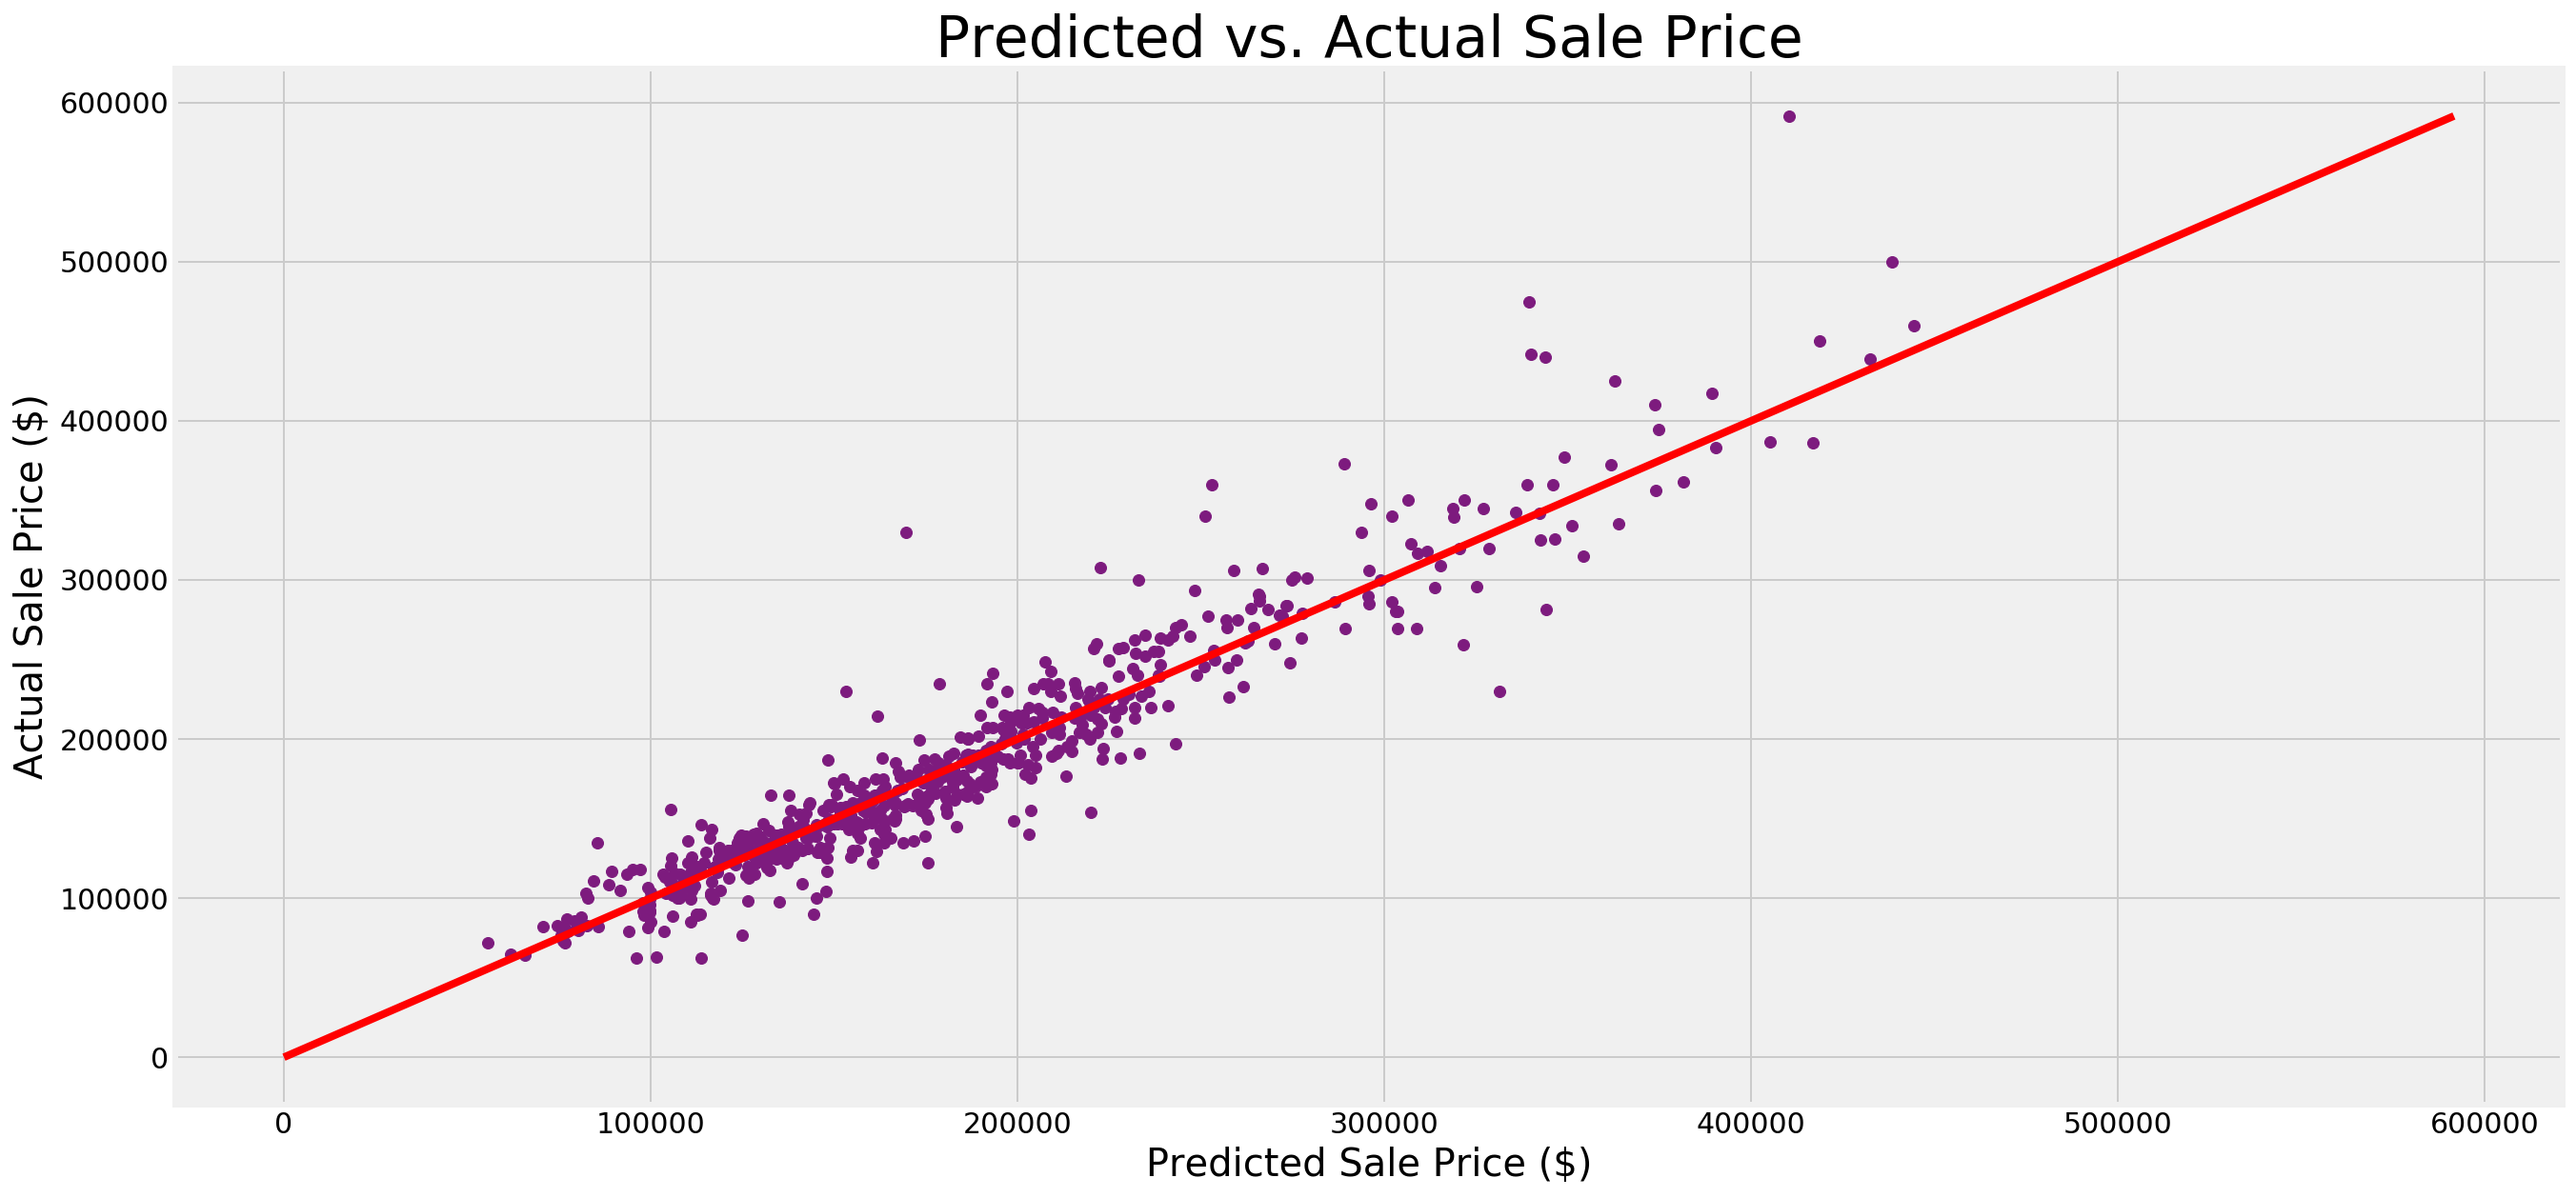

In [14]:
R2_train = lasso_cv.score(X_train_sc, y_train)
R2_test = lasso_cv.score(X_test_sc, y_test)
   
y_hat_lasso = lasso_cv.predict(X_test_sc)


plt.figure(figsize = (20,10))
plt.scatter(y_hat_lasso,y_test, c = DO);
plt.plot((0,np.max(y_test)),(0,np.max(y_test)), c = 'red');
plt.xlabel("Predicted Sale Price ($)", fontsize = 20);
plt.ylabel("Actual Sale Price ($)", fontsize = 20);
plt.title("Predicted vs. Actual Sale Price", fontsize = 30);
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

print(f'Train R2 Score: {R2_train}')
print(f'Test R2 Score: {R2_test}')

plt.savefig('../plots/y_vs_y_lasso.png')

In [15]:
model_score(y_test, y_hat_lasso)

Mean Absolute Error: 15966.39
Median Absolute Error: 11489.27
Root Mean Squared Error: 24356.89
R2: 0.9


I will now measure how many variables have been 'zeroed out' or removed by the lasso regression.

In [16]:
len(beta_df[beta_df['Absolute_Beta']==0]) / len(beta_df)

0.0

66% of the variables have been removed!

In [17]:
beta_df = beta_df[beta_df['Absolute_Beta'] != 0]

In [18]:
len(beta_df)

216

Only 72 predictor variables were used for the lasso model. 

Based on the lasso model's metrics, it has the lowest MAE score and number of predictor variables, while having the second lowest MedAE and RMSE scores, and the second highest $R^2$ score.

Based on the RMSE score, the lasso model can predict a house's price ± $24,356. 

Due to the substantially lower number of predictor variables along with its close metric scores compared to the ridge model, I believe the lasso model is the best out of the rest. 

| Metric | VT (0.01) | VT (0.05) | Ridge VT(0.01) | Lasso VT(0.01) |
|---|---|---|---|---|
| Mean Absolute Error | 17525 | 17436 | 16053 | <font color='red'> 15966 | 
| Median Absolute Error | 12403 | 12688 | <font color='red'>10675 |11489 |
| Root Mean Squared Error | 25249 | 25835 | <font color='red'>24096 | 24356 |
| R2 | 0.892 | 0.887 | <font color='red'>0.901 |0.900 | 
| # of  Predictor Variables | 216 | 128 | 216 | <font color='red'> 72 | 

In [19]:
beta_df = pd.DataFrame({'Predictor Variables' : predictor_variables, 'Beta':lasso_cv.coef_})
beta_df['Absolute_Beta'] = abs(beta_df['Beta'])
beta_df = beta_df.sort_values('Absolute_Beta', ascending = False)
beta_df = beta_df.reset_index(drop=True)
beta_df = beta_df.set_index('Predictor Variables')
beta_df = beta_df[beta_df['Absolute_Beta'] != 0] #removes coefficients of 0
beta_df.head(10)

Beta  Absolute_Beta
Predictor Variables                              
Gr_Liv_Area           19721.183769   19721.183769
Overall_Qual          14936.205926   14936.205926
Neighborhood_NridgHt   8191.094046    8191.094046
Kitchen_Qual_Ex        7752.316396    7752.316396
Garage_Cars            6815.896911    6815.896911
Bsmt_Qual_Ex           6357.467247    6357.467247
Neighborhood_NoRidge   5632.459112    5632.459112
Neighborhood_StoneBr   5271.175076    5271.175076
Bsmt_Full_Bath         4925.812813    4925.812813
Bsmt_Exposure_Gd       4618.087657    4618.087657

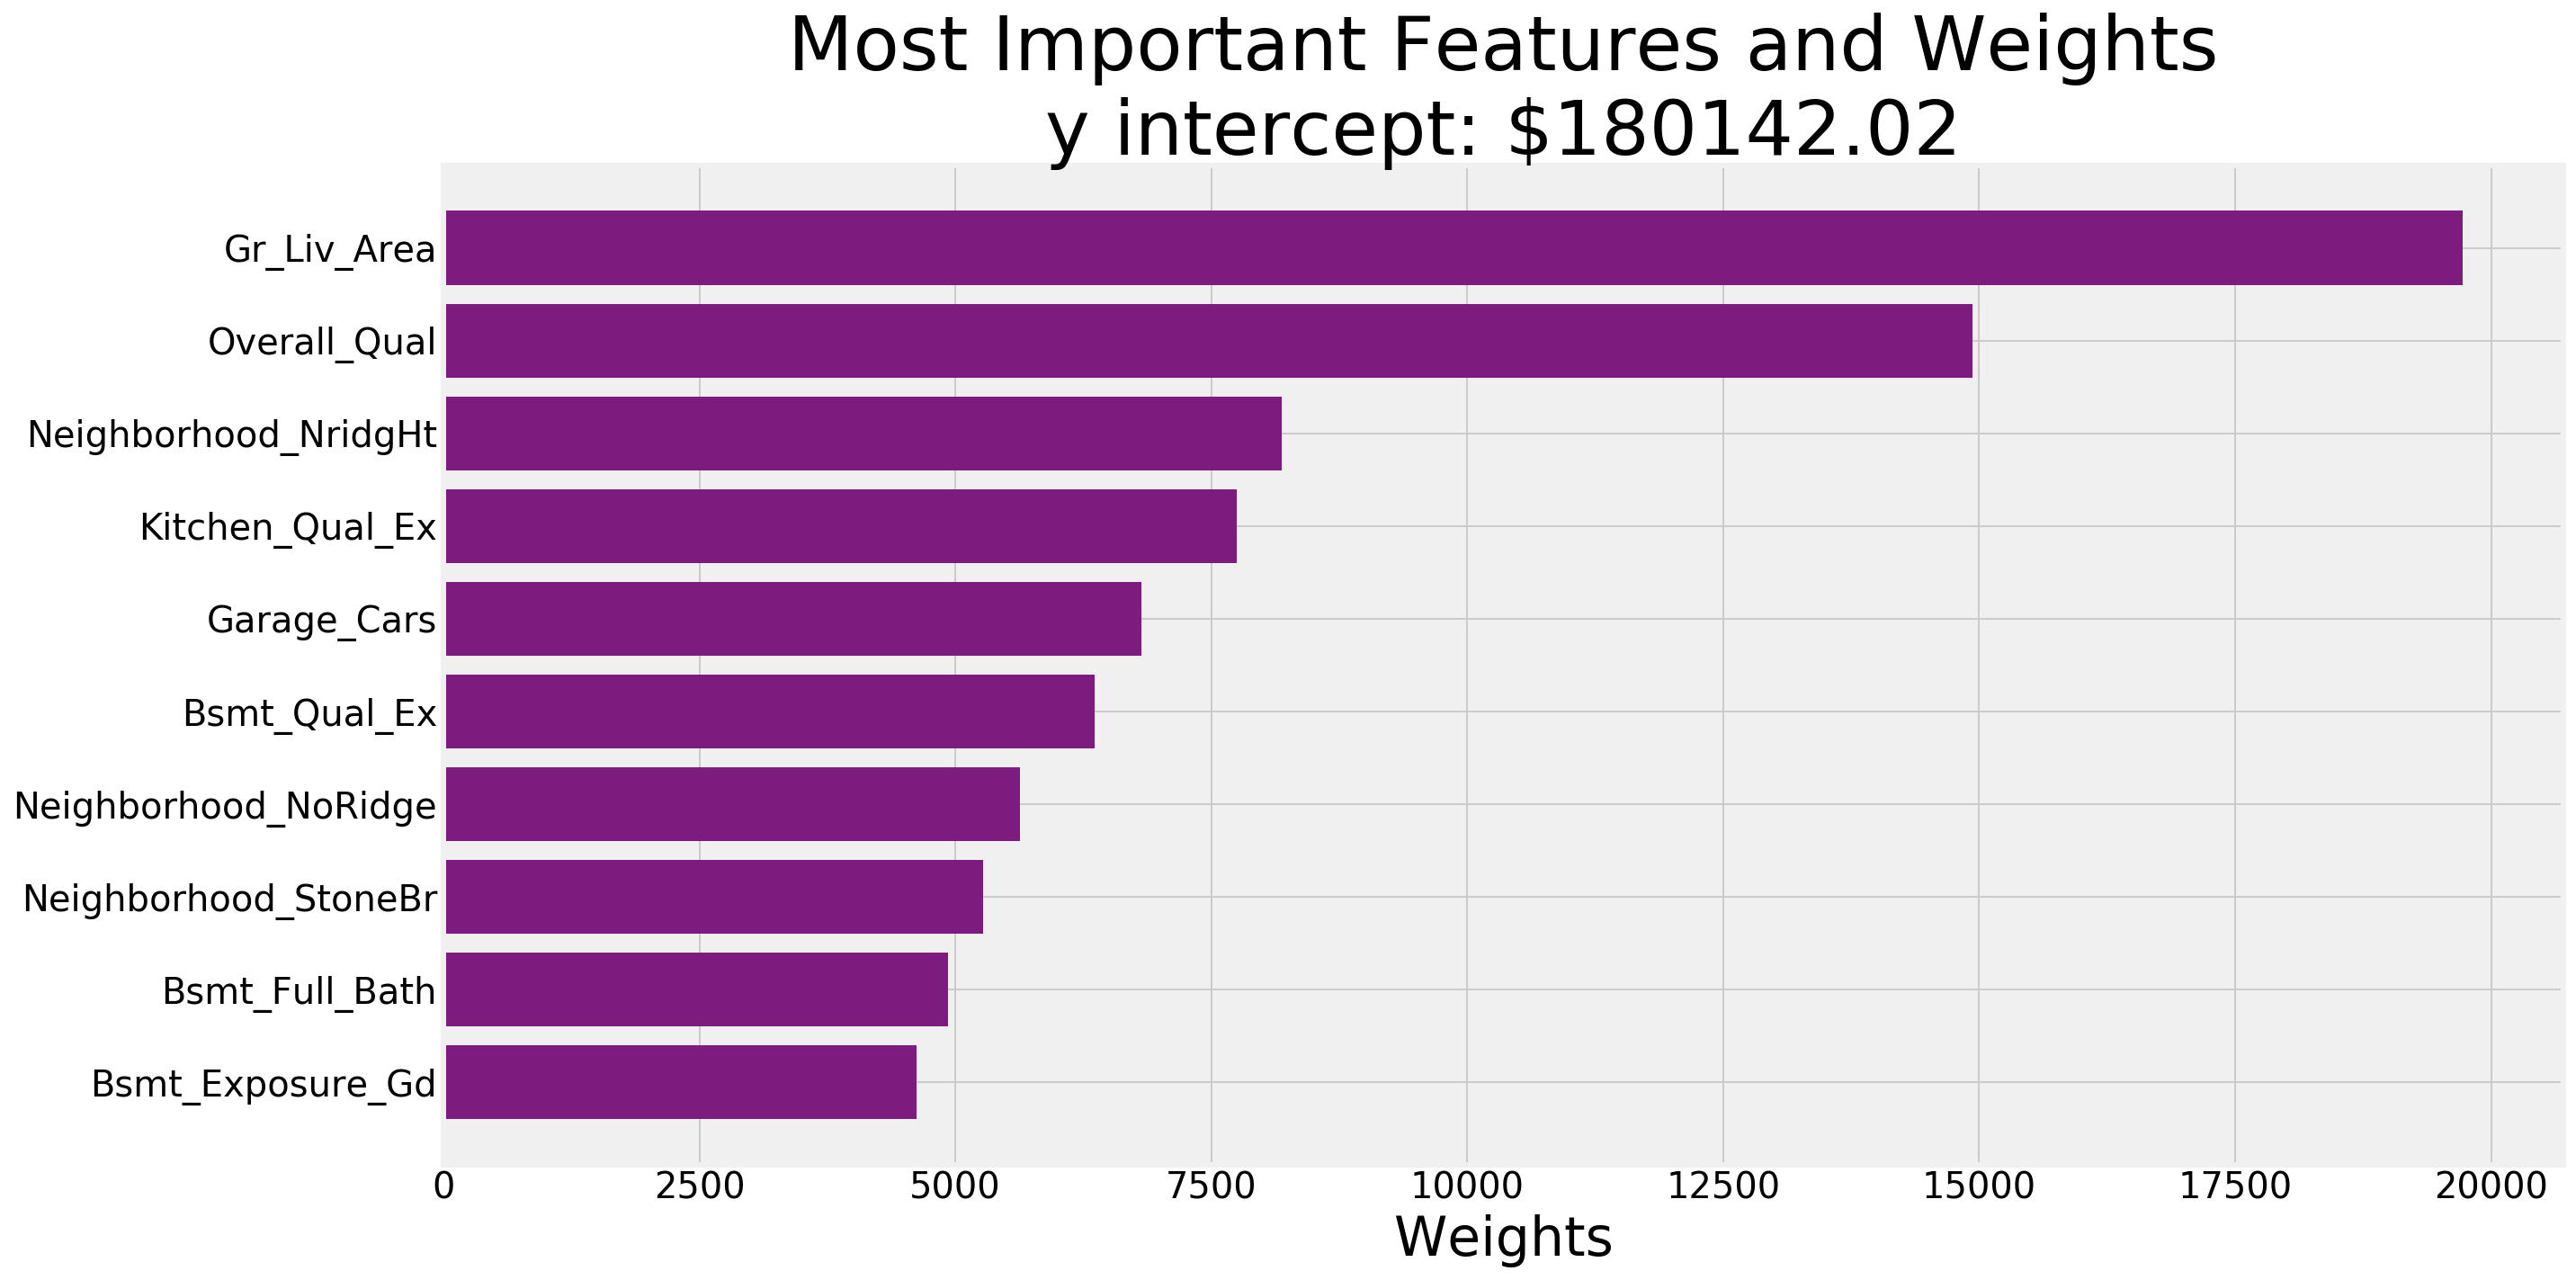

In [20]:
beta_0 = lasso_cv.intercept_
weights = beta_df['Absolute_Beta'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = DO)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

plt.savefig('../plots/beta_lasso.png')

# Conclusion:

Since I have decided that the Lasso model is the optimal model, the most important housing features are the following, from most to least important:

1. The ground living area in square feet
2. The house's overall quality
3. Whether the house is in Northridge Heights neighborhood
4. Whether the kitchen quality is excellent
- How many cars a garage can fit
- Whether the basement quality is excellent
- Whether the house is in Northridge neighborhood
- Whether the house is in Stone Brook neighborhood
- How many full basement bathrooms there are
- If the basement has good exposure to a walkout or garden wall.

While holding all other variables constant, if there is a one unit standard deviation increase in `Gr_Liv_Area`, then the `SalePrice` will increase by ~20000 standard deviations. The same process of interpretation can be applied for all other predictor variables and their coefficients.

According to what [millenials want](https://www.newhomesource.com/guide/articles/what-millennials-want-in-a-new-home),  66 percent prefer the suburbs, and 75 percent prefer a single-family home to a condo or apartment because they do not want to share walls. The top neighborhoods, Northridge Heights, Northridge, and Stonebrook, are all located in the suburbs. 

Millenials also prefer larger living spaces and kitchens for three reasons:

1. [Relationships:](https://www.vivint.com/resources/article/what-millennials-want-home) Millenials value relationships and friendships, so larger living spaces are ideal to host parties for friends and families.
2. Millenials prefer good quality kitchens in an open space where it can easily transition into the TV room or living room. Open space fosters more communication.
3. [Dogs:](https://www.prnewswire.com/news-releases/suntrust-survey-mortgages-are-going-to-the-dogs-300493476.html) 33 percent of millenials who purchased their first home say the desire to have a better space or yard for a dog influenced their decision to purchase their first home.

Millenials also want [energy efficient homes](https://www.ecowatch.com/millennials-climate-change-2482557556.html) because climate change is a global issue in which 78 percent of respondents to the Global Shaper Survey of over 31,000 millenials said they are willing to change their lifestyle to protect the environment. Ames accomodates this need as Ames prides itself as being a progressive green city, evidenced by their construction of a [$75-million water treatment plant](https://www.cityofames.org/about-ames/about-ames), and the Ames Power Plant has converted from coal-produced electricity to cleaner natural gas.

As millenials understand that the most important qualities in the house (determined by the lasso model) cater towards their needs, they can be reassured that the homes in Ames, Iowa are the perfect fit.

In [21]:
weights = beta_df['Beta'].sort_values(ascending=False)
labels = weights.index

def md_coef_table(labels, weights):
    print('| Feature | Weight |\n| --- | --- |')
    for i in range(len(labels)):
        print(f'| {labels[i]} | {weights[i]:.2e} |')
#md_coef_table(labels, weights);